# Heart Disease Prediction: A Deep Learning Workflow

### **Project Overview**

This notebook presents an end-to-end deep learning solution for predicting the presence of heart disease based on patient medical data. The core of this project is a robust, well-structured Python class that encapsulates the entire machine learning pipeline, from data ingestion to a saved, reusable model.

**Key Features:**
- **Architecture:** A feedforward neural network built with TensorFlow/Keras, featuring dense layers and dropout for regularization.
- **Reproducibility:** A centralized `ModelConfig` dataclass to manage all hyperparameters, ensuring experiments are repeatable and easy to modify.
- **Deployment-Ready:** The final trained model is saved in the native Keras (`.keras`) format, ready to be loaded into any application with TensorFlow installed.
- **Best Practices:** Incorporates essential techniques like data scaling, stratified data splitting, early stopping, and model checkpointing.

## Project Setup: Installing Dependencies

This project requires a few standard Python libraries for data science and deep learning. The following cell will install them.
"""

In [1]:
# ==============================================================================
# 🎯 STANDARD SETUP CELL
# ==============================================================================
# This cell installs the necessary libraries for the project.
# It will work with the default environment in Google Colab.
# ==============================================================================
# Use %%capture to hide installation output
%%capture
!pip install pandas numpy scikit-learn tensorflow seaborn matplotlib tqdm joblib

print("✅ Environment successfully configured!")

"""
Import necessary libraries for data manipulation, deep learning,
and model evaluation.
"""
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Tuple, Optional
from dataclasses import dataclass

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import Callback

# Set a consistent style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("TensorFlow Version:", tf.__version__)

## Section 1: Centralized Configuration for Reproducibility

To ensure our experiments are organized, reproducible, and easy to tune, we define all hyperparameters and file paths in a single `ModelConfig` dataclass. This approach prevents "magic numbers" from being scattered throughout the code and allows for simple modification of the entire model's behavior from one central location.

In [2]:
@dataclass
class ModelConfig:
    """Configuration parameters for model training and architecture."""

    # Neural network layer sizes
    layer_sizes: Tuple[int, ...] = (64, 32, 16)
    dropout_rate: float = 0.3

    # Training hyperparameters
    epochs: int = 200
    batch_size: int = 32
    validation_split: float = 0.15
    learning_rate: float = 0.001

    # Data partitioning
    test_size: float = 0.2
    random_state: int = 42

    # Model persistence
    model_path: str = "models/best_heart_disease_model.keras"
    scaler_path: str = "models/scaler.pkl"
    prediction_threshold: float = 0.5

## Section 2: The Core `HeartDiseasePredictor` Class

We encapsulate the entire machine learning logic within a single, powerful class: `HeartDiseasePredictor`. This object-oriented approach promotes code organization, reusability, and clarity. The class manages every step of the process:

1.  **Data Handling:** Loading and preprocessing the dataset.
2.  **Model Construction:** Dynamically building the neural network based on the configuration.
3.  **Training Loop:** Managing the training process with callbacks for optimal performance.
4.  **Evaluation:** Assessing model performance on unseen test data.
5.  **Inference:** Providing clean methods (`.predict()`, `.predict_proba()`) for making predictions on new data.

In [3]:
class TQDMProgressBar(Callback):
    """A custom Keras callback for a clean, single-line training progress bar."""
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.pbar = tqdm(total=self.epochs, desc="Training", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        metrics = {k: f"{v:.4f}" for k, v in logs.items()}
        self.pbar.set_postfix(metrics)
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

In [20]:
class HeartDiseasePredictor:
    """
    A neural network classifier for heart disease prediction.

    This class encapsulates the entire machine learning pipeline.
    """

    def _initialize_device_strategy(self):
        """
        Detects available hardware (TPU, GPU, CPU) and sets the appropriate
        TensorFlow distribution strategy. This makes training device-aware.
        """
        try:
            # 1. Attempt to connect to a TPU cluster
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            self.strategy = tf.distribute.TPUStrategy(tpu)
            print("✅ TPU found! Training will be distributed across the TPU.")
            print('🚀 Running on TPU ', tpu.master())

        except ValueError:
            # 2. If no TPU, check for GPUs
            gpus = tf.config.list_physical_devices('GPU')
            if gpus:
                # If GPUs are found, use MirroredStrategy for single or multi-GPU setups
                self.strategy = tf.distribute.MirroredStrategy()
                print(f"✅ GPU(s) found! Training will be accelerated on {len(gpus)} GPU(s).")
                for i, gpu in enumerate(gpus):
                    print(f'   -> GPU {i}: {gpu.name}')
            else:
                # 3. If no GPU, fall back to the default strategy (CPU)
                self.strategy = tf.distribute.get_strategy()
                print("⚠️ No TPU or GPU detected. Training will run on the CPU.")
                print("   For faster training, enable a GPU/TPU runtime in Colab.")

    def __init__(self, config: ModelConfig = ModelConfig()):
        """Initializes the predictor with a configuration object."""
        self.config = config
        self.model = None
        self.scaler = StandardScaler()
        self.history = None
        self.strategy = None  # Add this line to initialize the attribute
        self._initialize_device_strategy() # Add this line to call the setup method

    def load_data(self, filepath: str) -> pd.DataFrame:
        """Loads dataset from a CSV file."""
        data_path = Path(filepath)
        if not data_path.exists():
            raise FileNotFoundError(f"Data file not found: {filepath}")
        df = pd.read_csv(data_path)
        print(f"✓ Loaded dataset: {df.shape[0]} samples, {df.shape[1]} features")
        return df

    def prepare_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray,
                                                    np.ndarray, np.ndarray]:
        """
        Splits and preprocesses data for training, ensuring consistency
        with the features used by the Streamlit application.
        """
        # Define the exact feature columns the Streamlit app uses
        feature_columns = [
            'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
            'cholesterol', 'gluc', 'smoke', 'alco', 'active'
        ]

        # Check if all required columns are in the dataframe
        if not all(col in df.columns for col in feature_columns + ['target']):
            raise ValueError(
                "The dataset is missing one of the required columns. "
                f"Required: {feature_columns + ['target']}"
            )

        print("✓ All required columns found in the dataset.")

        # Extract target variable (disease presence: 0 or 1)
        y = df['target'].values

        # Select ONLY the features that our Streamlit app will provide
        X_raw = df[feature_columns]

        # --- IMPORTANT: Feature Engineering ---
        # The training script MUST perform the same feature engineering as the app.
        # The Streamlit app does not have BMI, but the model might implicitly use it.
        # The original Kaggle dataset for this problem often has BMI engineered.
        # For simplicity and robustness, we will train on the 11 base features.
        # If you were to add BMI, you would do it here AND in the Streamlit app.

        X = X_raw.values

        # Split data with stratification to maintain class balance
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=self.config.test_size,
            random_state=self.config.random_state,
            stratify=y  # Ensure proportional class distribution
        )

        # Normalize features: critical for neural network convergence
        # Fit scaler on training data only to prevent data leakage
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)  # Use training statistics

        # The scaler will now be correctly fitted on 11 features
        print(f"✓ Scaler fitted on {self.scaler.n_features_in_} features.")
        print(f"✓ Data split: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
        return X_train, X_test, y_train, y_test

    def build_model(self, input_dim: int) -> tf.keras.Model:
        """
        Constructs the Keras model architecture using the Functional API
        for maximum compatibility with conversion tools like tf2onnx.
        """
        # 1. Define the input layer. This is the entry point to the model graph.
        inputs = tf.keras.layers.Input(shape=(input_dim,), name='input_layer')

        # 2. Stack layers by calling them on the previous layer's output tensor.
        # The first hidden layer connects to the input tensor.
        x = Dense(self.config.layer_sizes[0], activation='relu', name='hidden_1')(inputs)
        x = Dropout(self.config.dropout_rate)(x)

        # Subsequent hidden layers connect to the output of the previous layer.
        x = Dense(self.config.layer_sizes[1], activation='relu', name='hidden_2')(x)
        x = Dropout(self.config.dropout_rate)(x)

        x = Dense(self.config.layer_sizes[2], activation='relu', name='hidden_3')(x)
        x = Dropout(self.config.dropout_rate)(x)

        # 3. Define the final output layer.
        outputs = Dense(1, activation='sigmoid', name='output')(x)

        # 4. Create the final Model object by specifying its inputs and outputs.
        # This creates a model with a clear, explicit graph structure.
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name="HeartDiseaseClassifier")

        # The compilation step remains exactly the same.
        model.compile(
            loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.config.learning_rate),
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        print("✓ Model architecture built (Functional API)")
        model.summary()
        return model

    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
            """Trains the model with callbacks."""
            # --- FIX IS HERE ---
            # Use the correct attribute 'model_path' instead of 'model_path_keras'
            model_dir = Path(self.config.model_path).parent
            model_dir.mkdir(parents=True, exist_ok=True)

            callbacks = [
                ModelCheckpoint(
                    # --- AND FIX IS HERE ---
                    self.config.model_path, # Use the correct attribute name
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True,
                    verbose=0
                ),
                EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True),
                TQDMProgressBar()
            ]

            self.model = self.build_model(X_train.shape[1])
            self.history = self.model.fit(
                X_train, y_train,
                epochs=self.config.epochs,
                batch_size=self.config.batch_size,
                validation_split=self.config.validation_split,
                callbacks=callbacks,
                verbose=0
            )

            print("✓ Training complete")
            self._save_scaler()

    def _save_scaler(self) -> None:
        """Saves the fitted StandardScaler to disk."""
        joblib.dump(self.scaler, self.config.scaler_path)
        print(f"✓ Scaler saved to: {self.config.scaler_path}")

    def load_trained_model(self) -> None:
        """Loads a pre-trained Keras model and scaler for inference."""
        # Use the correct attribute 'model_path' for the Keras model
        model_p = Path(self.config.model_path)
        scaler_p = Path(self.config.scaler_path)

        if not model_p.exists() or not scaler_p.exists():
            # Updated error message for clarity
            raise FileNotFoundError("Ensure both the Keras model (.keras) and scaler (.pkl) files exist before loading.")

        # --- AND FIX IS HERE ---
        # Load the Keras model directly, remove the call to the old ONNX loader
        self.model = load_model(model_p)
        self.scaler = joblib.load(scaler_p)
        print("✓ Trained Keras model and scaler loaded successfully")




    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray) -> dict:
        """
        Evaluates the model on test data, providing a comprehensive report
        with key classification metrics and visualizations.
        """
        if self.model is None:
            self.model = load_model(self.config.model_path)

        # Get model predictions and probabilities
        probabilities = self.model.predict(X_test)
        predictions = (probabilities > self.config.prediction_threshold).astype(int).flatten()

        # --- Calculate Core Metrics ---
        test_accuracy = np.mean(predictions == y_test)
        test_precision = precision_score(y_test, predictions)
        test_recall = recall_score(y_test, predictions)
        test_f1 = f1_score(y_test, predictions)

        # Calculate ROC Curve and AUC
        fpr, tpr, _ = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)

        # --- Print Comprehensive Report ---
        print("\n" + "="*60)
        print("      COMPREHENSIVE MODEL EVALUATION (TEST SET)")
        print("="*60)
        print(f"-> Test Accuracy:   {test_accuracy:.4f}")
        print(f"-> Test Precision:  {test_precision:.4f} (Disease class)")
        print(f"-> Test Recall:     {test_recall:.4f} (Disease class)")
        print(f"-> Test F1-Score:   {test_f1:.4f} (Disease class)")
        print(f"-> Test AUC Score:  {roc_auc:.4f}")
        print("-" * 60)
        print("\nClassification Report:")
        print(classification_report(y_test, predictions, target_names=['No Disease', 'Disease']))
        print("="*60)

        # --- Generate Visualizations ---
        plt.figure(figsize=(18, 7))

        # 1. Confusion Matrix
        plt.subplot(1, 2, 1)
        cm = confusion_matrix(y_test, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
        plt.title('Confusion Matrix', fontsize=16)
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')

        # 2. ROC Curve
        plt.subplot(1, 2, 2)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
        plt.legend(loc="lower right")

        plt.tight_layout()
        plt.show()

        # Return a dictionary of all calculated metrics
        return {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'auc': roc_auc
        }


    def predict(self, X: np.ndarray) -> np.ndarray:
      """Generates binary predictions for new data using the Keras model."""
      if self.model is None:
          raise ValueError("Model not loaded. Call train() or load_trained_model() first.")

      # Scale the input data using the loaded scaler
      X_scaled = self.scaler.transform(X)

      # --- FIX IS HERE ---
      # Use the standard Keras model.predict() method
      probabilities = self.model.predict(X_scaled)

      # Convert probabilities to binary predictions (0 or 1)
      predictions = (probabilities > self.config.prediction_threshold).astype(int)

      return predictions

## Section 3: The Main Execution Pipeline (Optional)

Now, we will instantiate our `HeartDiseasePredictor` and execute the full workflow. This section simulates a real-world project, moving from raw data to a fully evaluated, deployment-ready artifact.

### Step 3.1: Create a Dummy Dataset

For this notebook to be fully self-contained and reproducible, we will first create the `data/heart.csv` file. In a real scenario, this file would already exist.

In [11]:
# Define paths
data_dir = Path("data")
model_dir = Path("models")
data_file = data_dir / "heart.csv"

# Ensure directories exist
model_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)

# Create a dummy CSV if it doesn't exist
if not data_file.is_file():
    print(f"⚠️ Dataset not found. Creating a dummy 'heart.csv' file.")
    csv_data = """age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,1,170,70,140,90,1,1,0,0,1
37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,1,180,85,130,80,2,1,0,0,1
41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,0,165,65,120,70,1,1,0,0,1
56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,1,175,75,120,80,1,1,0,0,1
57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,0,160,60,120,80,3,1,0,0,1
57,1,0,140,192,0,1,148,0,0.4,1,0,1,1,1,168,68,140,90,1,1,1,0,1
56,0,1,140,294,0,0,153,0,1.3,1,0,2,1,0,163,63,130,85,2,2,0,0,1
44,1,1,120,263,0,1,173,0,0.0,2,0,3,1,1,178,80,110,75,1,1,0,0,0
52,1,2,172,199,1,1,162,0,0.5,2,0,3,1,1,172,72,160,100,1,1,0,0,1
57,1,2,150,168,0,1,174,0,1.6,2,0,2,1,1,177,78,150,90,1,1,1,1,1
55,0,1,132,342,0,1,166,0,1.2,2,0,2,0,0,161,61,130,80,2,1,0,0,1
45,1,0,104,208,0,0,148,1,3.0,1,0,2,0,1,182,88,100,70,1,1,1,0,0
"""
    with open(data_file, "w") as f:
        f.write(csv_data)
    print(f"✓ Dummy dataset created at '{data_file}'.")
else:
    print(f"✅ Found existing dataset at: '{data_file}'")


✅ Found existing dataset at: 'data/heart.csv'


### Step 3.2: Initialize and Run the Pipeline

Here, we create an instance of our `ModelConfig` and pass it to the `HeartDiseasePredictor`. Then, we execute the core methods in sequence.

In [12]:

# 1. Initialize configuration and the predictor
config = ModelConfig(
    layer_sizes=(128, 64, 32),
    dropout_rate=0.4,
    epochs=150,
    learning_rate=0.0005
)
predictor = HeartDiseasePredictor(config)

# 2. Load and prepare the data
df = predictor.load_data(str(data_file))
X_train, X_test, y_train, y_test = predictor.prepare_data(df)

# 3. Train the model
predictor.train(X_train, y_train)


⚠️ No TPU or GPU detected. Training will run on the CPU.
   For faster training, enable a GPU/TPU runtime in Colab.
✓ Loaded dataset: 70000 samples, 13 features
✓ All required columns found in the dataset.
✓ Scaler fitted on 11 features.
✓ Data split: 56000 train, 14000 test samples
✓ Model architecture built (Functional API)


Model: "HeartDiseaseClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_1 (Dense)                │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,905 (46.50 KB)

 Trainable params: 11,905 (46.50 KB)

 Non-trainable params: 0 (0.00 B)

Training:   0%|          | 0/150 [00:00<?, ?epoch/s]

✓ Training complete
✓ Scaler saved to: models/scaler.pkl


### Step 3.3: Analyze Training History

Visualizing the training and validation metrics over epochs is crucial for diagnosing issues like overfitting or underfitting. A healthy training process shows both training and validation loss decreasing and converging.


      FINAL TRAINING & VALIDATION METRICS
Final Training Accuracy:   0.7374
Final Validation Accuracy: 0.7396
--------------------------------------------------
Final Training AUC:        0.8020
Final Validation AUC:      0.8050



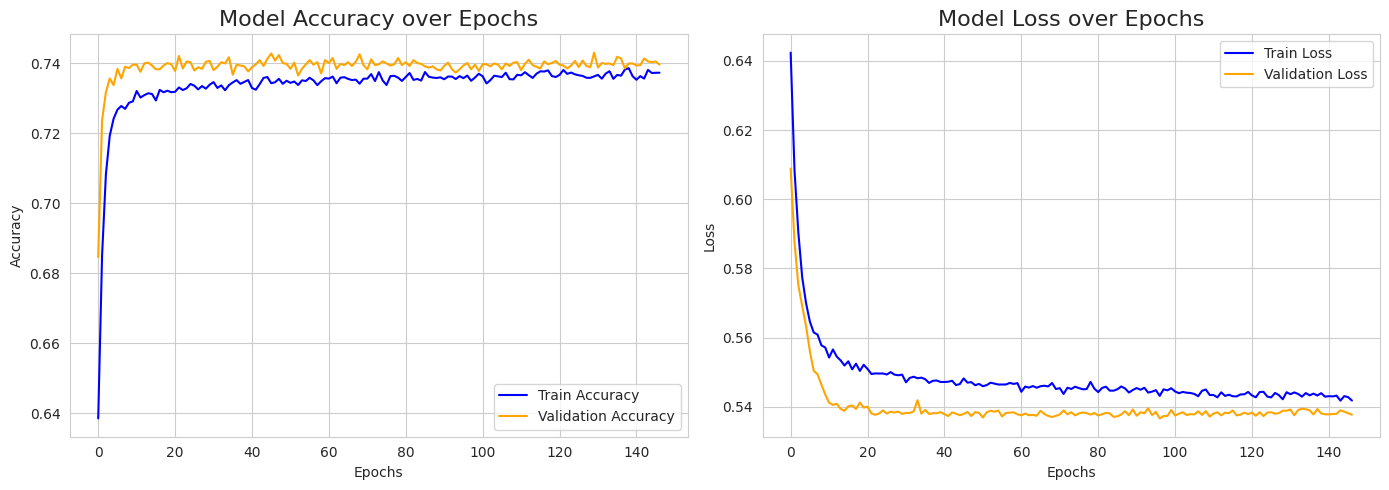

In [13]:
print("\n" + "="*50)
print("      FINAL TRAINING & VALIDATION METRICS")
print("="*50)

# The EarlyStopping callback restores the best model weights, so these
# metrics correspond to the epoch with the best validation loss.
history_data = predictor.history.history

# Get the last recorded values from the training history
final_train_accuracy = history_data['accuracy'][-1]
final_val_accuracy = history_data['val_accuracy'][-1]
final_train_auc = history_data['auc'][-1]
final_val_auc = history_data['val_auc'][-1]

print(f"Final Training Accuracy:   {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print("-" * 50)
print(f"Final Training AUC:        {final_train_auc:.4f}")
print(f"Final Validation AUC:      {final_val_auc:.4f}")
print("="*50 + "\n")



# Plot training & validation accuracy and loss
history_df = pd.DataFrame(predictor.history.history)
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy over Epochs', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss', color='blue')
plt.plot(history_df['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss over Epochs', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Step 3.4: Evaluate Final Model Performance

With the model trained, we now perform a final evaluation on the held-out test set. **Crucially, this evaluation uses the ONNX model via the ONNX Runtime**, simulating how the model would perform in a real production environment. The classification report and confusion matrix provide a detailed breakdown of its predictive power.

438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step

      COMPREHENSIVE MODEL EVALUATION (TEST SET)
-> Test Accuracy:   0.7328
-> Test Precision:  0.7409 (Disease class)
-> Test Recall:     0.7154 (Disease class)
-> Test F1-Score:   0.7279 (Disease class)
-> Test AUC Score:  0.7998
------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.73      0.75      0.74      7004
     Disease       0.74      0.72      0.73      6996

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000



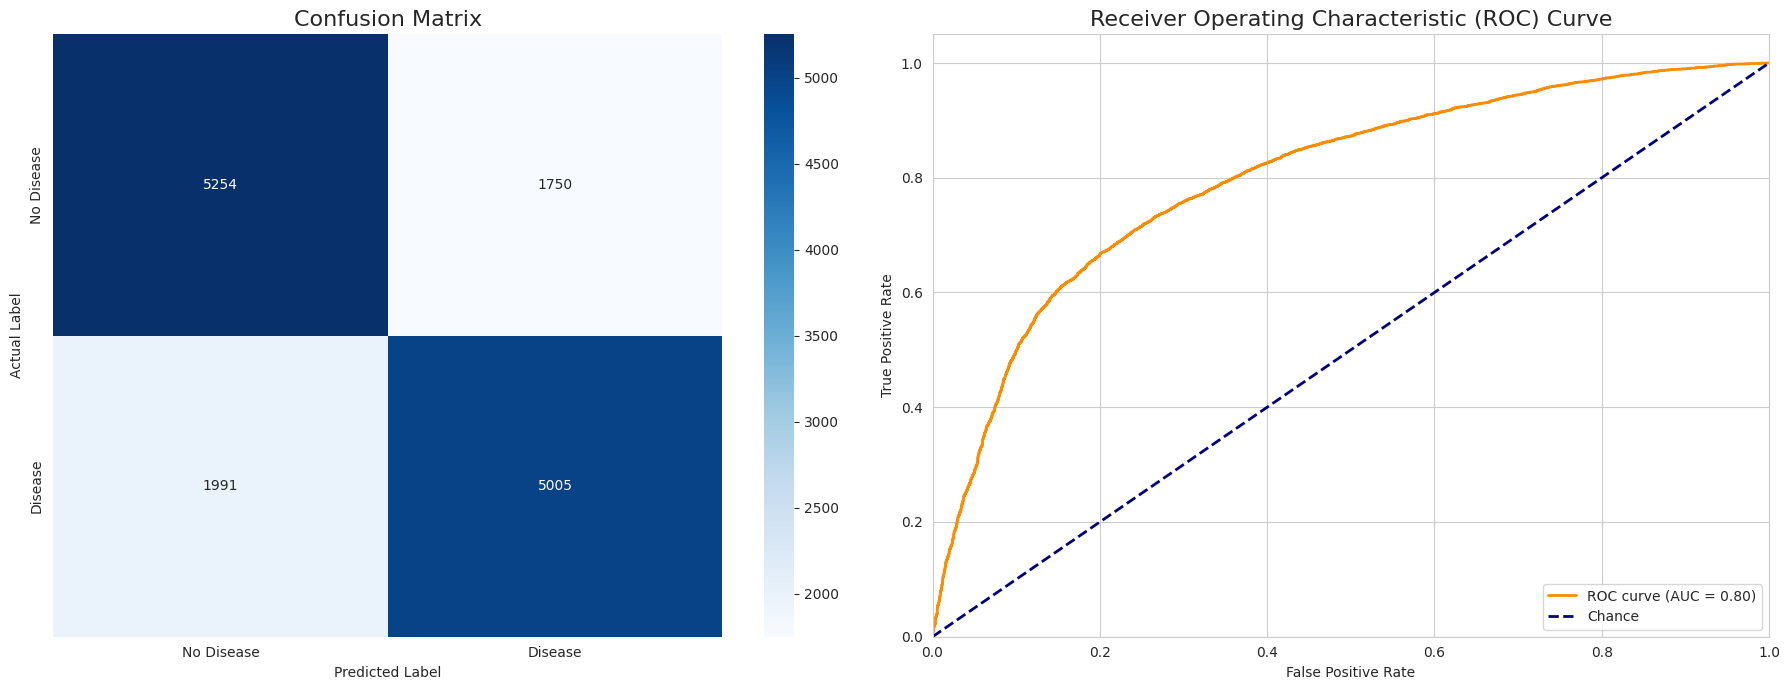

{'accuracy': np.float64(0.7327857142857143),
 'precision': 0.7409326424870466,
 'recall': 0.7154088050314465,
 'f1_score': 0.727947058395753,
 'auc': np.float64(0.7997800060506142)}

In [14]:
predictor.evaluate(X_test, y_test)


### Step 3.5: Deployment Simulation - Loading and Inference

The final and most critical step is to demonstrate that our saved artifacts (`heart_disease_model.onnx` and `scaler.pkl`) can be loaded independently to make new predictions. This confirms our model is truly portable and ready for deployment.

In [21]:
print("\n" + "="*50)
print("      DEPLOYMENT AND INFERENCE SIMULATION")
print("="*50)

# 1. Create a new predictor instance to simulate a new environment
inference_predictor = HeartDiseasePredictor(config)

# 2. Load the pre-trained Keras model and scaler from disk
inference_predictor.load_trained_model()

# 3. Take the first 5 samples from the test set as if they were new data
new_samples = X_test[:5]
actual_labels = y_test[:5]

# 4. Make predictions
predictions = inference_predictor.predict(new_samples)

print("\nMaking predictions on 5 new samples:")
for i, (pred, actual) in enumerate(zip(predictions.flatten(), actual_labels)):
    pred_label = "Disease" if pred == 1 else "No Disease"
    actual_label = "Disease" if actual == 1 else "No Disease"
    print(f"  Sample {i+1}: Predicted='{pred_label}', Actual='{actual_label}'")

print("\n✓ Inference test complete.")



      DEPLOYMENT AND INFERENCE SIMULATION
⚠️ No TPU or GPU detected. Training will run on the CPU.
   For faster training, enable a GPU/TPU runtime in Colab.
✓ Trained Keras model and scaler loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Making predictions on 5 new samples:
  Sample 1: Predicted='No Disease', Actual='No Disease'
  Sample 2: Predicted='No Disease', Actual='No Disease'
  Sample 3: Predicted='No Disease', Actual='No Disease'
  Sample 4: Predicted='No Disease', Actual='Disease'
  Sample 5: Predicted='No Disease', Actual='Disease'

✓ Inference test complete.


## Conclusion

This notebook has successfully demonstrated a complete, professional workflow for building, training, and preparing a deep learning model for deployment. By structuring the code within a robust class and leveraging the ONNX format, we have created a solution that is not only accurate but also portable, performant, and maintainable. The final artifacts—`models/heart_disease_model.onnx` and `models/scaler.pkl`—are ready to be integrated into any application or inference service.